![dvd_image](dvd_image.jpg)

A DVD rental company needs your help! They want to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yeilds a MSE of 3 or less on a test set. The model you make will help the company become more efficient inventory planning.

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

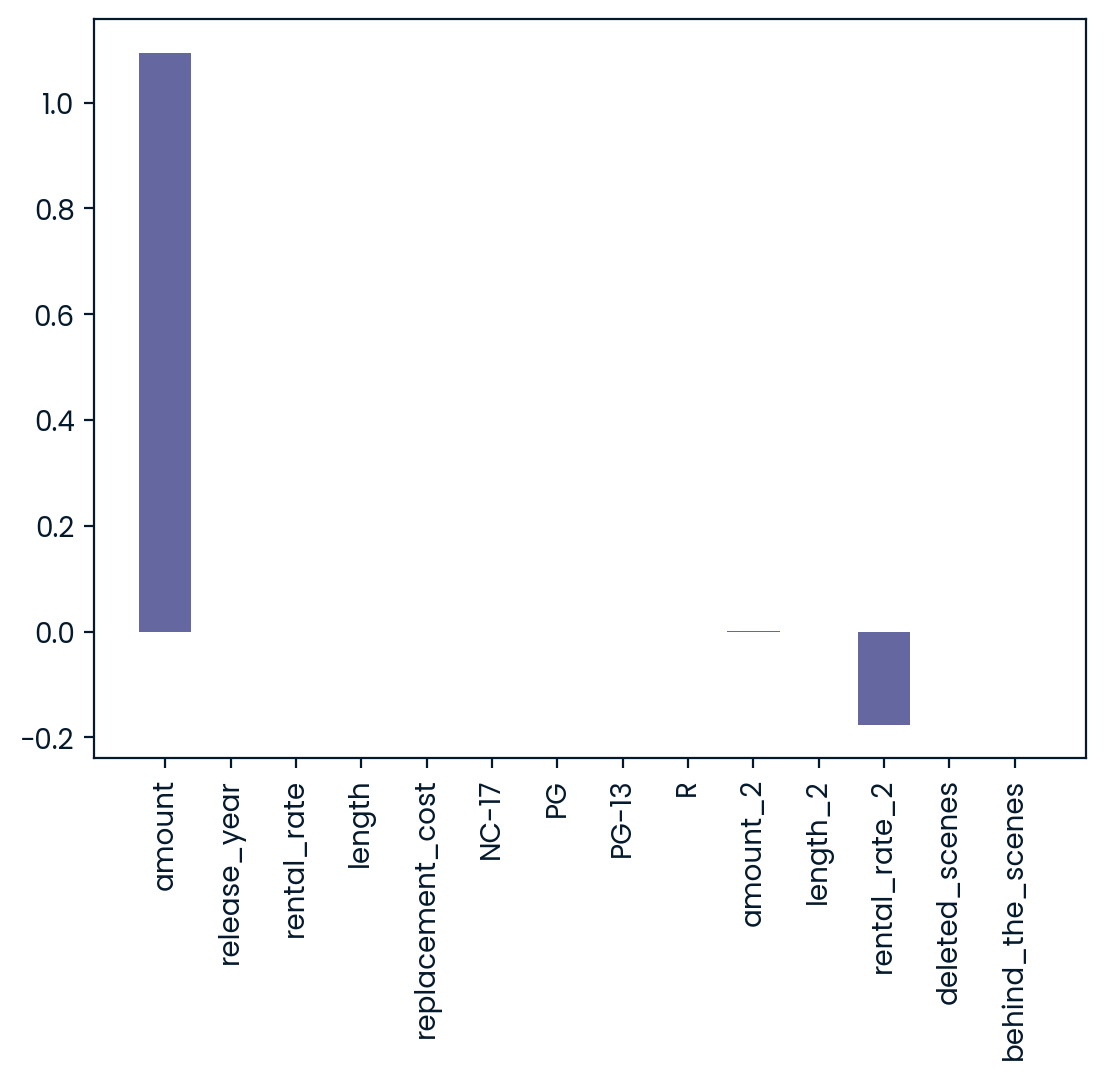

Best Model: RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fa46d061130>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fa46d308ca0>},
                   random_state=9)
Best MSE: 2.2830477008789334


In [7]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, LinearRegression
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from sklearn.metrics import mean_squared_error as MSE


# Import any additional modules and start coding below
#Read csv data
dvd_data = pd.read_csv('rental_info.csv')
#EDA
 #print(dvd_data.head())
 #print(dvd_data.info())
 #print(dvd_data['special_features'].value_counts())
# Convert 'rental_date' and 'return_date' to datetime
dvd_data['rental_date'] = pd.to_datetime(dvd_data['rental_date'])
dvd_data['return_date'] = pd.to_datetime(dvd_data['return_date'])

# Calculate rental length in days
dvd_data['rental_length_days'] = (dvd_data['return_date'] - dvd_data['rental_date']).dt.days

 #print(dvd_data['rental_length_days'].head())
# Create dummy variables for Deleted scened and Behind the scenes.
dvd_data['deleted_scenes'] = np.where(dvd_data['special_features'].str.contains("Deleted Scenes"),1,0)
dvd_data['behind_the_scenes'] = np.where(dvd_data['special_features'].str.contains("Behind the Scenes"),1,0)
# Drop non-mumeric columns as they cannot be used directly in regression
dvd_data = dvd_data.drop(['rental_date', 'return_date', 'special_features'], axis=1)
# Pick the features that influence model the most and split data to train and test sets
SEED = 9
y = dvd_data['rental_length_days']
X = dvd_data.drop('rental_length_days', axis=1)
names = dvd_data.drop('rental_length_days', axis=1).columns
lasso = Lasso(random_state=SEED, alpha=0.1)
lasso_coef = lasso.fit(X, y).coef_
plt.bar(names, lasso_coef)
plt.xticks(rotation = 90)
plt.show()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
models = {'Linear Regression':LinearRegression(), 'Decision Tree': DecisionTreeRegressor(), 'Random Forest': RandomForestRegressor()}
params_model = {
    'Decision Tree': {'max_depth': sp_randInt(4, 10)},
    'Random Forest': {'n_estimators': sp_randInt(10, 100), 'max_depth': sp_randInt(4, 10)}
}
results = []
for name, model in models.items():
    if name in params_model:
        random_model = RandomizedSearchCV(estimator=model, param_distributions=params_model[name], cv=10, random_state=SEED, n_jobs=-1)
    else:
        random_model = model
    random_model.fit(X_train, y_train)
    results.append(random_model)
    
best_model = max(results, key=lambda model: model.best_score_ if hasattr(model, 'best_score_') else model.score(X_test, y_test))
y_pred = best_model.predict(X_test)
best_mse = MSE(y_test, y_pred)
print(f"Best Model: {best_model}")
print(f"Best MSE: {best_mse}")